In [1]:
import random
import math
import numpy as np
import pandas as pd
from math import sqrt as sqrt
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import scipy.stats as stats

from statsmodels.tsa.api import SARIMAX

import copulae

from proj_1 import *

seed = 8227185 #for sigma to sq repara

In [2]:
y_test_heave = pd.read_csv("heave_filter_test.csv", header = None)
y_test_heave = y_test_heave[0]
p1 = 30 
y_heave = pd.read_csv("heave_filter_train.csv", header = None)
y_heave = y_heave[0]
N1 = len(y_heave)
np.random.seed(seed)

#create my x matrix
X_temp = pd.DataFrame()
for i in range(p1-1,0-1,-1):
    X = y_heave[(i):(N1-p1+i)]
    X_temp["lag"+str(p1-i)] = list(X) #has memory of its index 
X_heave = X_temp.to_numpy()
y_heave = np.array(y_heave[p1:N1])


In [3]:
sarimax_mod = SARIMAX(y_heave, order=(p1, 0, 0), trend="n")
sarimax_res1 = sarimax_mod.fit()
print(sarimax_res1.summary())

sarimax_params = sarimax_res1.arparams
results_as_html = sarimax_res1.summary().tables[1].as_html()
res_pd = pd.read_html(results_as_html, header=0, index_col=0)[0]
sarimax_sig = list(res_pd["coef"])[-1]
#sarimax_sig = np.var(sarimax_res1.resid)
non_restricted = np.arctanh(ARToPacf(sarimax_params))
param_i = list(non_restricted) + [sq_to_sigma2(sarimax_sig)]

c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2970
Model:              SARIMAX(30, 0, 0)   Log Likelihood               23224.212
Date:                Wed, 07 Aug 2024   AIC                         -46386.423
Time:                        18:19:25   BIC                         -46200.537
Sample:                             0   HQIC                        -46319.526
                               - 2970                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          3.2841      0.001   4839.270      0.000       3.283       3.285
ar.L2         -2.5375      0.001  -2787.778      0.000      -2.539      -2.536
ar.L3         -1.1119      0.001  -1016.363      0.0

C:\Users\danie\AppData\Local\Temp\ipykernel_14932\1376903461.py:7: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  res_pd = pd.read_html(results_as_html, header=0, index_col=0)[0]


In [4]:
#my fn

np.random.seed(seed)
results1 = minimize(neg_log_lik, param_i, args = ((y_heave, X_heave)), method = "L-BFGS-B")
print("psi approx",barndorff_schou_transformation(np.tanh(results1.x[0:p1])), "sigma2 approx",sigma2_to_exp(results1.x[-1]))
print("final negative log likelihood", results1.fun)

#forecast values 
phi_approx = barndorff_schou_transformation(np.tanh(results1.x[0:p1]))
forecast_param = predicting_values(y_heave, p1, N1, phi_approx, forecast_len = 125)

#fitting values 
phi_approx = barndorff_schou_transformation(np.tanh(results1.x[0:p1]))
phi_approx = np.array(phi_approx)
#phi_approx = sarimax_res.arparams # to check if identical fitting values
fitted_heave = fitting_values(y_heave,p1, phi_approx)

#mse for fitted 
print("MSE of fitted to true for SARIMAX initials", mse(y_heave[p1:N1], fitted_heave))
print("MSE of fitted to true for SARIMAX initials", mse(y_test_heave , forecast_param))

[ 3.28412393 -2.5375474  -1.11192246  0.31917126  1.37178611  0.79315301
 -0.1817135  -0.64811503 -0.97402396 -0.3523111   0.45517534  0.70370218
  0.38172716  0.19614181 -0.20173616 -0.60600852 -0.29420446 -0.18026193
  0.29811858  0.31285428  0.41134657 -0.06857211 -0.18730493 -0.45718949
 -0.05304362  0.26622521  0.21690484 -0.01822412 -0.22572377  0.08732262] 1.000094983455678 2729.3885008244533
[ 3.28412393 -2.5375474  -1.11192246  0.31917126  1.37178611  0.79315301
 -0.1817135  -0.64811503 -0.97402396 -0.3523111   0.45517534  0.70370218
  0.38172716  0.19614181 -0.20173616 -0.60600852 -0.29420446 -0.18026193
  0.29811858  0.31285428  0.41134657 -0.06857211 -0.18730493 -0.45718949
 -0.05304362  0.26622521  0.21690484 -0.01822412 -0.22572377  0.08732262] 1.000094983455678 2729.3885008244497
[ 3.28412393 -2.5375474  -1.11192246  0.31917126  1.37178611  0.79315301
 -0.1817135  -0.64811503 -0.97402396 -0.3523111   0.45517534  0.70370218
  0.38172716  0.19614181 -0.20173616 -0.60600852

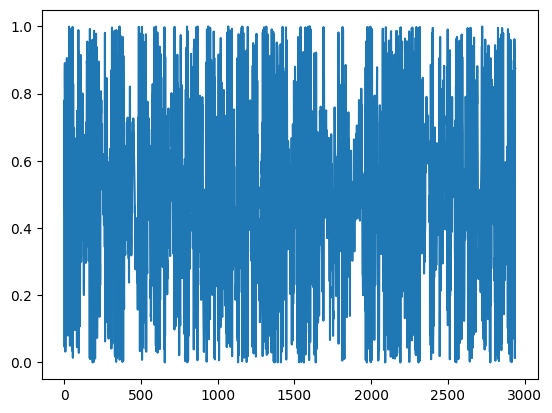

In [5]:
# Transform to uniform marginals
U_1t_sim = stats.norm.cdf(y_heave[p1:(len(y_heave)+1)], fitted_heave, np.sqrt(sigma2_to_exp(results1.x[-1]) ) ) #pnorm
data_sim = pd.DataFrame(U_1t_sim, columns = ["U_1t_sim"])
data_sim.to_csv("U_1t_heave_nods.csv")

plt.plot(U_1t_sim)
plt.show()

[-6.77947397e+00 -2.66543866e+01 -7.70780442e+01 -1.80143874e+02
 -3.57320104e+02 -6.18819112e+02 -9.51842936e+02 -1.31274675e+03
 -1.62865375e+03 -1.81151829e+03 -1.78253107e+03 -1.49945403e+03
 -9.76413396e+02 -2.87132517e+02  4.51008169e+02  1.10798815e+03
  1.57605630e+03  1.79704637e+03  1.77270680e+03  1.55615594e+03
  1.22941888e+03  8.76592626e+02  5.62445206e+02  3.22123290e+02
  1.62339939e+02  7.03756782e+01  2.52994871e+01  7.06688822e+00
  1.35195596e+00  1.12060236e-01] 1.4481247624973872 207296881386.0729
[-6.77947397e+00 -2.66543866e+01 -7.70780442e+01 -1.80143874e+02
 -3.57320104e+02 -6.18819112e+02 -9.51842936e+02 -1.31274675e+03
 -1.62865375e+03 -1.81151829e+03 -1.78253107e+03 -1.49945403e+03
 -9.76413395e+02 -2.87132517e+02  4.51008169e+02  1.10798815e+03
  1.57605630e+03  1.79704637e+03  1.77270680e+03  1.55615594e+03
  1.22941888e+03  8.76592625e+02  5.62445205e+02  3.22123290e+02
  1.62339939e+02  7.03756782e+01  2.52994871e+01  7.06688822e+00
  1.35195595e+00  1

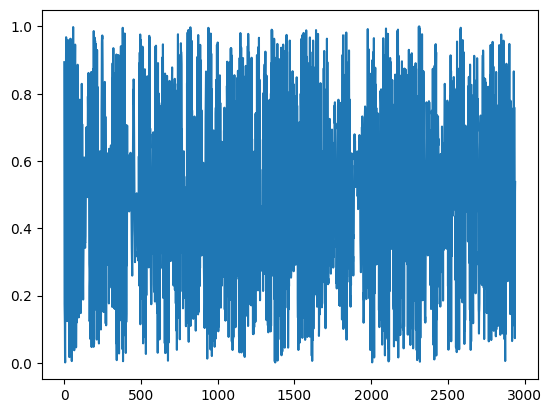

MSE of fitted to true for SARIMAX initials 6.617631095222275e-07
MSE of fitted to true for SARIMAX initials 3.3009067515603894


In [6]:
#my fn
seed = 1235
np.random.seed(seed)

param_i = [np.random.uniform() for i in range(p1+1)]

results1_np = minimize(neg_log_lik, param_i, args = ((y_heave, X_heave)), method = "L-BFGS-B")
print("psi approx",barndorff_schou_transformation(np.tanh(results1_np.x[0:p1])), "sigma2 approx",sigma2_to_exp(results1_np.x[-1]))
print("final negative log likelihood", results1_np.fun)

#forecast values 
phi_approx = barndorff_schou_transformation(np.tanh(results1_np.x[0:p1]))
forecast_noparam = predicting_values(y_heave, p1, N1, phi_approx, forecast_len = 125)

#fitting values 
phi_approx = np.array(phi_approx)
#phi_approx = sarimax_res.arparams # to check if identical fitting values
fitted_heave_np = fitting_values(y_heave,p1, phi_approx)

U_1t_sim = stats.norm.cdf(y_heave[p1:(len(y_heave)+1)], fitted_heave_np, np.sqrt(sigma2_to_exp(results1_np.x[-1]) ) ) #pnorm
data_sim = pd.DataFrame(U_1t_sim, columns = ["U_1t_sim"])
#data_sim.to_csv("U_1t.csv")

plt.plot(U_1t_sim)
plt.show()

#mse for fitted 
print("MSE of fitted to true for SARIMAX initials", mse(y_heave[p1:N1], fitted_heave_np))
print("MSE of fitted to true for SARIMAX initials", mse(y_test_heave , forecast_noparam))

In [7]:
#prepping graph arrays

sarimax_ci_down = sarimax_res1.get_forecast(125).summary_frame()["mean_ci_lower"]
sarimax_ci_up = sarimax_res1.get_forecast(125).summary_frame()["mean_ci_upper"]

y_graph = list(y_heave[-125:3000])
y_graph = y_graph + list(y_test_heave)

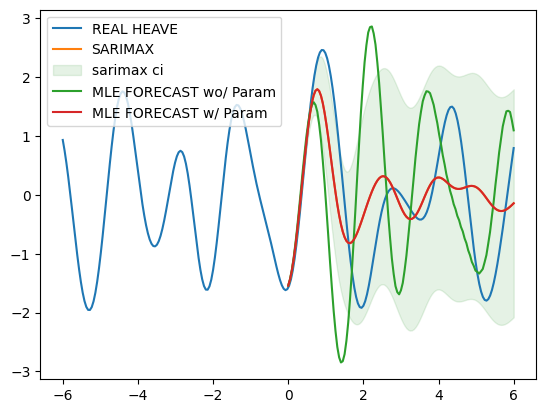

In [8]:
fig, ax = plt.subplots()
ax.plot(np.linspace(-6,6,250),y_graph)


ax.plot(np.linspace(0,6,125),sarimax_res1.forecast(125))
ax.fill_between(np.linspace(0,6,125), sarimax_ci_up, sarimax_ci_down, color='green', alpha=.1)

plt.plot(np.linspace(0,6,125),forecast_noparam)
plt.plot(np.linspace(0,6,125),forecast_param)

plt.legend([ "REAL HEAVE","SARIMAX", "sarimax ci",  "MLE FORECAST wo/ Param", "MLE FORECAST w/ Param"])

plt.show()

incident

In [9]:
y_test_incident = pd.read_csv("incident_filter_test.csv", header = None)
y_test_incident = y_test_incident[0]
p2 = 40 
y_incident = pd.read_csv("incident_filter_train.csv", header = None)
y_incident = y_incident[0]
N2 = len(y_incident)
np.random.seed(seed)

#create my x matrix
X_temp = pd.DataFrame()
for i in range(p2-1,0-1,-1):
    X = y_incident[(i):(N2-p2+i)]
    X_temp["lag"+str(p2-i)] = list(X) #has memory of its index 
X_incident = X_temp.to_numpy()
y_incident = np.array(y_incident[p2:N2])


In [10]:
sarimax_mod = SARIMAX(y_incident, order=(p2, 0, 0), trend="n")
sarimax_res2 = sarimax_mod.fit()
print(sarimax_res2.summary())

sarimax_params = sarimax_res2.arparams
results_as_html = sarimax_res2.summary().tables[1].as_html()
res_pd = pd.read_html(results_as_html, header=0, index_col=0)[0]
sarimax_sig = list(res_pd["coef"])[-1]
#sarimax_sig = np.var(sarimax_res2.resid)
non_restricted = np.arctanh(ARToPacf(sarimax_params))
param_i = list(non_restricted) + [sq_to_sigma2(sarimax_sig)]

c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2960
Model:              SARIMAX(40, 0, 0)   Log Likelihood               16241.458
Date:                Wed, 07 Aug 2024   AIC                         -32400.916
Time:                        18:19:51   BIC                         -32155.205
Sample:                             0   HQIC                        -32312.474
                               - 2960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          5.9931      0.008    740.803      0.000       5.977       6.009
ar.L2        -14.8698      0.041   -365.586      0.000     -14.950     -14.790
ar.L3         17.7376      0.085    207.787      0.0

C:\Users\danie\AppData\Local\Temp\ipykernel_14932\1436654552.py:7: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  res_pd = pd.read_html(results_as_html, header=0, index_col=0)[0]


In [11]:
#my fn

np.random.seed(seed)
results2 = minimize(neg_log_lik, param_i, args = ((y_incident, X_incident)), method = "L-BFGS-B")
print("psi approx",barndorff_schou_transformation(np.tanh(results2.x[0:p2])), "sigma2 approx",sigma2_to_exp(results2.x[-1]))
print("final negative log likelihood", results2.fun)

#forecast values 
phi_approx = barndorff_schou_transformation(np.tanh(results2.x[0:p2]))
forecast_param_incident = predicting_values(y_incident, p2, N2, phi_approx, forecast_len = 125)

#fitting values 
phi_approx = barndorff_schou_transformation(np.tanh(results2.x[0:p2]))
phi_approx = np.array(phi_approx)
#phi_approx = sarimax_res.arparams # to check if identical fitting values
fitted_incident = fitting_values(y_incident,p2, phi_approx)

#mse for fitted 
print("MSE of fitted to true for SARIMAX initials", mse(y_incident[p2:N2], fitted_incident))
print("MSE of fitted to true for SARIMAX initials", mse(y_test_incident , forecast_param_incident))

[ 5.99309922e+00 -1.48697822e+01  1.77375808e+01 -6.14506969e+00
 -7.73953006e+00  5.43510483e+00  5.27057049e+00 -3.85372644e+00
 -4.29847138e+00  1.94572607e+00  3.86655512e+00 -1.34981260e-01
 -3.67371455e+00 -7.64766899e-01  2.56312195e+00  1.72090681e+00
 -1.43295118e+00 -2.14178471e+00  8.00697326e-03  2.65067818e+00
  5.66238215e-01 -2.19104176e+00 -8.88155903e-01  7.58261933e-01
  1.98076471e+00 -1.94853588e-01 -2.36512386e+00  1.35328496e-02
  1.97068154e+00 -1.14478296e-02 -5.38564361e-01 -1.62608778e+00
  1.71913071e+00  2.22628004e-01 -4.83193808e-01 -6.19132218e-01
  7.82690240e-01 -1.86168184e-01 -8.44081352e-02  3.68949496e-02] 1.0009863867632647 2721.5194961139714
[ 5.99309922e+00 -1.48697822e+01  1.77375808e+01 -6.14506969e+00
 -7.73953007e+00  5.43510483e+00  5.27057050e+00 -3.85372644e+00
 -4.29847138e+00  1.94572607e+00  3.86655512e+00 -1.34981260e-01
 -3.67371455e+00 -7.64766900e-01  2.56312195e+00  1.72090681e+00
 -1.43295118e+00 -2.14178472e+00  8.00697335e-03  2

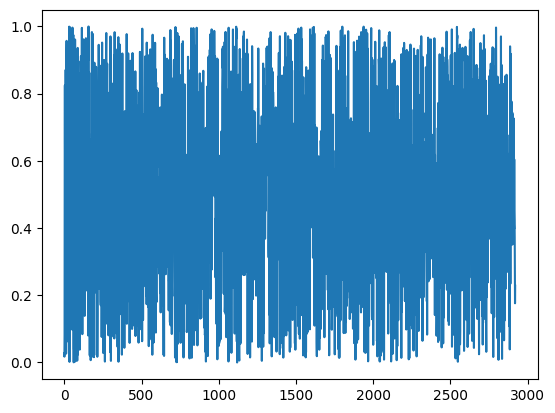

In [12]:
# Transform to uniform marginals
U_1t_sim = stats.norm.cdf(y_incident[p2:(len(y_incident)+1)], fitted_incident, np.sqrt(sigma2_to_exp(results2.x[-1]) ) ) #pnorm
data_sim = pd.DataFrame(U_1t_sim, columns = ["U_1t_sim"])
data_sim.to_csv("U_2t_incident_nods.csv")

plt.plot(U_1t_sim)
plt.show()

[-7.74917122e+00 -3.36814291e+01 -1.06950338e+02 -2.75602725e+02
 -6.08591491e+02 -1.18945110e+03 -2.10080586e+03 -3.40087788e+03
 -5.09600112e+03 -7.11582108e+03 -9.29897016e+03 -1.13965442e+04
 -1.30975262e+04 -1.40751476e+04 -1.40470157e+04 -1.28367535e+04
 -1.04223639e+04 -6.95811246e+03 -2.76248218e+03  1.72735448e+03
  6.02601864e+03  9.68067104e+03  1.23445490e+04  1.38278936e+04
  1.41165380e+04  1.33563159e+04  1.18093455e+04  9.79458491e+03
  7.62713952e+03  5.56916946e+03  3.80040163e+03  2.41044476e+03
  1.40957581e+03  7.51316540e+02  3.59070563e+02  1.50187128e+02
  5.29376651e+01  1.47546935e+01  2.88575068e+00  2.93419828e-01] 1.532497522983784 38774355697783.234
[-7.74917121e+00 -3.36814291e+01 -1.06950337e+02 -2.75602725e+02
 -6.08591490e+02 -1.18945110e+03 -2.10080586e+03 -3.40087788e+03
 -5.09600111e+03 -7.11582106e+03 -9.29897014e+03 -1.13965442e+04
 -1.30975262e+04 -1.40751475e+04 -1.40470156e+04 -1.28367535e+04
 -1.04223639e+04 -6.95811244e+03 -2.76248217e+03  1.

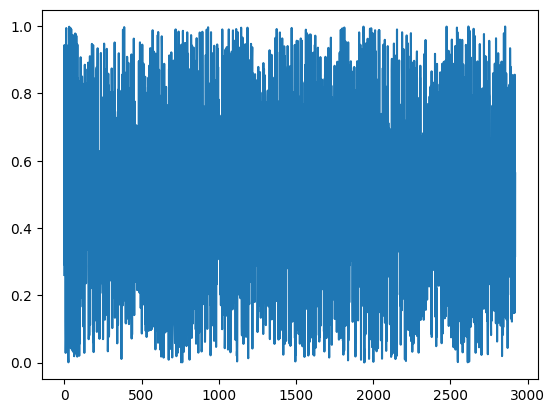

MSE of fitted to true for SARIMAX initials 2.495771082199764e-06
MSE of fitted to true for SARIMAX initials 3.513238614591996


In [13]:
#my fn
seed = 702209
np.random.seed(seed)

param_i = [np.random.uniform() for i in range(p2+1)]

results2_np = minimize(neg_log_lik, param_i, args = ((y_incident, X_incident)), method = "L-BFGS-B")
print("psi approx",barndorff_schou_transformation(np.tanh(results2_np.x[0:p2])), "sigma2 approx",sigma2_to_exp(results2_np.x[-1]))
print("final negative log likelihood", results2_np.fun)

#forecast values 
phi_approx = barndorff_schou_transformation(np.tanh(results2_np.x[0:p2]))
forecast_noparam_incident = predicting_values(y_incident, p2, N2, phi_approx, forecast_len = 125)

#fitting values 
phi_approx = np.array(phi_approx)
#phi_approx = sarimax_res.arparams # to check if identical fitting values
fitted_incident_np = fitting_values(y_incident,p2, phi_approx)

U_1t_sim = stats.norm.cdf(y_incident[p2:(len(y_incident)+1)], fitted_incident_np, np.sqrt(sigma2_to_exp(results2_np.x[-1]) ) ) #pnorm
data_sim = pd.DataFrame(U_1t_sim, columns = ["U_1t_sim"])
#data_sim.to_csv("U_1t.csv")

plt.plot(U_1t_sim)
plt.show()

#mse for fitted 
print("MSE of fitted to true for SARIMAX initials", mse(y_incident[p2:N2], fitted_incident_np))
print("MSE of fitted to true for SARIMAX initials", mse(y_test_incident , forecast_noparam_incident))

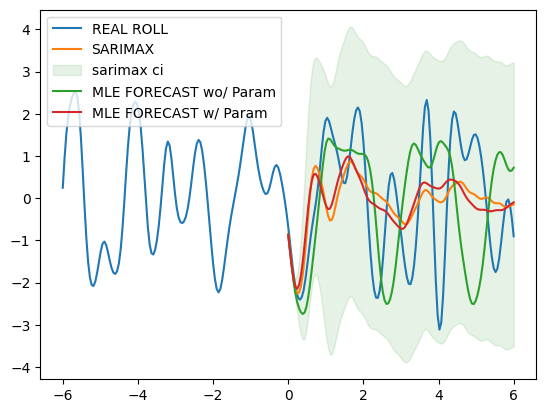

In [14]:
#prepping graph arrays

sarimax_ci_down = sarimax_res2.get_forecast(125).summary_frame()["mean_ci_lower"]
sarimax_ci_up = sarimax_res2.get_forecast(125).summary_frame()["mean_ci_upper"]

y_graph = list(y_incident[-125:3000])
y_graph = y_graph + list(y_test_incident)


fig, ax = plt.subplots()
ax.plot(np.linspace(-6,6,250),y_graph)


ax.plot(np.linspace(0,6,125),sarimax_res2.forecast(125))
ax.fill_between(np.linspace(0,6,125), sarimax_ci_up, sarimax_ci_down, color='green', alpha=.1)

plt.plot(np.linspace(0,6,125),forecast_noparam_incident)
plt.plot(np.linspace(0,6,125),forecast_param_incident)

plt.legend([ "REAL ROLL","SARIMAX", "sarimax ci",  "MLE FORECAST wo/ Param", "MLE FORECAST w/ Param"])

plt.show()

In [15]:
pd.read_csv("U_1t_heave_nods.csv")


Unnamed: 0  U_1t_sim
0              0  0.459705
1              1  0.780217
2              2  0.046186
3              3  0.858386
4              4  0.891058
...          ...       ...
2935        2935  0.917983
2936        2936  0.391587
2937        2937  0.012969
2938        2938  0.878510
2939        2939  0.875943

[2940 rows x 2 columns]

In [16]:
pd.read_csv("U_2t_incident_nods.csv")

Unnamed: 0  U_1t_sim
0              0  0.026703
1              1  0.017411
2              2  0.083130
3              3  0.663046
4              4  0.824753
...          ...       ...
2915        2915  0.423619
2916        2916  0.371951
2917        2917  0.228171
2918        2918  0.176197
2919        2919  0.228521

[2920 rows x 2 columns]

0       0.678787
1       0.520820
2       0.262903
3       0.083139
4       0.080217
          ...   
2915    0.917983
2916    0.391587
2917    0.012969
2918    0.878510
2919    0.875943
Name: U_1t_sim, Length: 2920, dtype: float64 0       0.026703
1       0.017411
2       0.083130
3       0.663046
4       0.824753
          ...   
2915    0.423619
2916    0.371951
2917    0.228171
2918    0.176197
2919    0.228521
Name: U_1t_sim, Length: 2920, dtype: float64


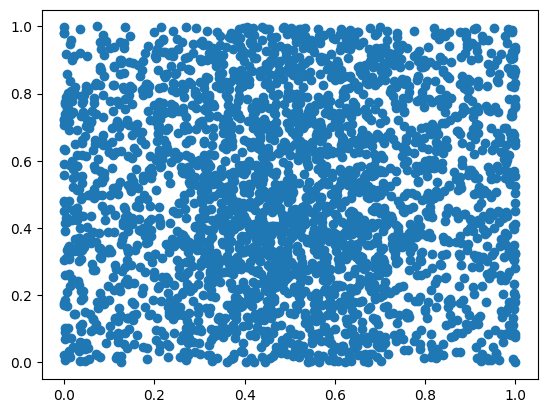

U_1t         U_2t
count  2920.000000  2920.000000
mean      0.499244     0.498944
std       0.275489     0.263379
min       0.000062     0.000009
25%       0.280536     0.310347
50%       0.490345     0.495940
75%       0.731265     0.686171
max       0.999763     0.999982

In [17]:
U_1t = pd.read_csv("U_1t_heave_nods.csv")
U_1t = U_1t[20:2940] #to make same length
U_1t.reset_index(inplace = True)
U_1t = U_1t["U_1t_sim"]
U_2t = pd.read_csv("U_2t_incident_nods.csv")
U_2t = U_2t["U_1t_sim"]
print(U_1t, U_2t)
plt.scatter(U_1t, U_2t)
plt.show()
data = pd.DataFrame({"U_1t" : U_2t, "U_2t" : U_1t})
display(data.describe())
data = data.to_numpy()

In [18]:
cop = copulae.archimedean.ClaytonCopula() #dim = 2 == default
cop.fit(data)
print(cop.summary())
print(cop.log_lik(data))

Clayton Copula Summary
Clayton Copula with 2 dimensions


Parameters
--------------------------------------------------------------------------------
       theta        : 0.007145165876933944

0.07283170007065098


In [19]:
from scipy import stats
tau = stats.kendalltau(data[:,0], data[:,1])[0]
tau
2 * tau / (1 - tau)

0.013140534946085452

In [20]:
inita = exp_to_theta(2 * tau / (1 - tau) +1) #sq_to_theta

#results = minimize(neg_log_clayton_pdf, [inita], args = ((rd1, rd2)), method = "nelder-mead")
results = minimize(neg_log_clayton_pdf, x0 = [inita], args = ((data[:,0], data[:,1])), method = "L-BFGS-B")

theta 2.75400150581922
neg log clayton 3309.101833975251
theta 2.7540015333592356
neg log clayton 3309.10188367913
theta 1.0131405349460854
neg log clayton 679.1901294139827
theta 1.0131405450774909
neg log clayton 679.1901406291435
theta 0.7570444471555944
neg log clayton 417.98259732817974
theta 0.7570444547260389
neg log clayton 417.98260435051833
theta 0.464699513753135
neg log clayton 182.1236268275326
theta 0.46469951840013013
neg log clayton 182.123629969311
theta 0.3130213644876433
neg log clayton 91.32762606392672
theta 0.3130213676178569
neg log clayton 91.32762768155312
theta 0.205803059524799
neg log clayton 42.852048344123375
theta 0.2058030615828296
neg log clayton 42.852049133619914
theta 0.13798310316513973
neg log clayton 20.13579549916662
theta 0.13798310454497076
neg log clayton 20.13579589023214
theta 0.09319866317265751
neg log clayton 9.151959864629042
theta 0.09319866410464414
neg log clayton 9.151960055615977
theta 0.06408217429396539
neg log clayton 4.034217966

Clayton Copula Summary
Clayton Copula with 2 dimensions


Parameters
--------------------------------------------------------------------------------
       theta        : 0.009844970732415042



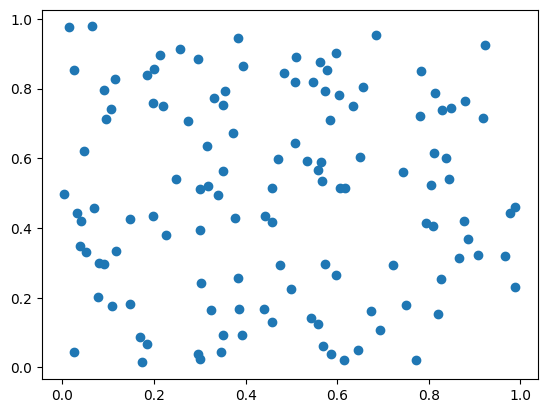

In [21]:
cop = copulae.archimedean.ClaytonCopula(theta = theta_to_exp(results.x +1)) #dim = 2 == default
print(cop.summary())
u_gen = cop.random(125, seed = 10)

plt.scatter(u_gen[:,0], u_gen[:,1])

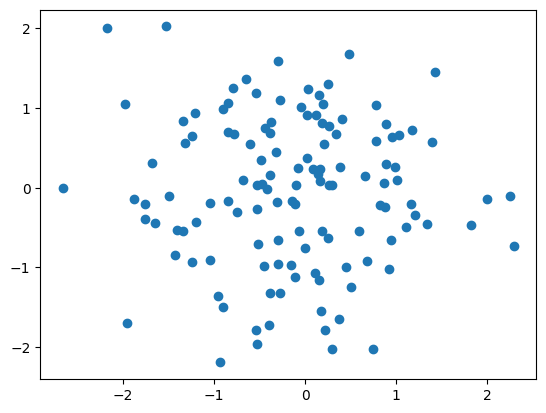

In [22]:
e_1t = stats.norm.ppf(u_gen[:,0])
e_2t = stats.norm.ppf(u_gen[:,1])
plt.scatter(e_1t, e_2t)

In [23]:
#import clayton
#from clayton.rng.archimedean import Clayton
#np.random.seed(10)
#cop = Clayton(theta=-0.028833624534288258, n_samples=125)
#u_gen = cop.sample_unimargin()
#
#plt.scatter(u_gen[:,0], u_gen[:,1])
#plt.show()
#e_1t = stats.norm.ppf(u_gen[:,0])
#e_2t = stats.norm.ppf(u_gen[:,1])
#plt.scatter(e_1t, e_2t)

In [24]:
horizon = 125
repeats = 10000
pi_1, pi_2, forecast1_param_copula, forecast2_param_copula, pi_1b, pi_2b, forecast1b_param, forecast2b_param = predict_copula_pi(cop, y_heave, y_incident, results1, results2, p1, p2, N1, N2, repeats = repeats, horizon = horizon, seed = 10)

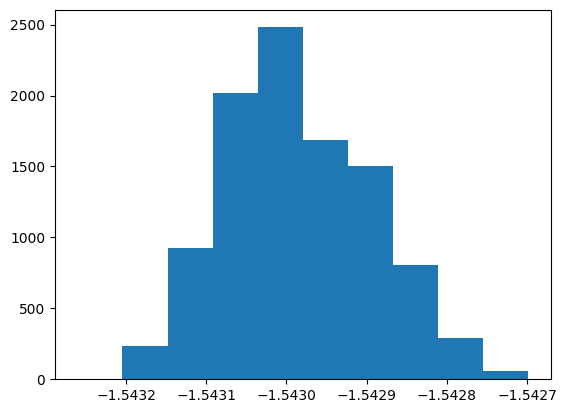

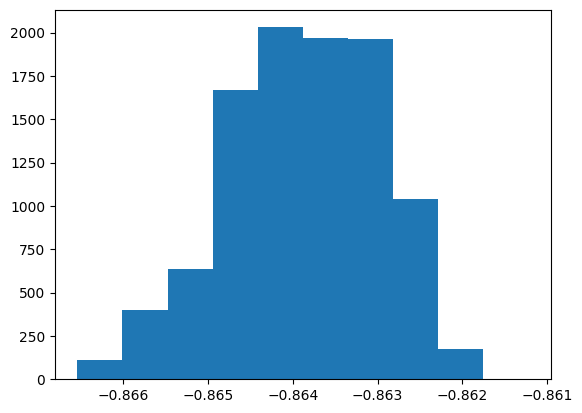

In [25]:
plt.hist(pi_1[0,:])
plt.show()
plt.hist(pi_2[0,:])
plt.show()

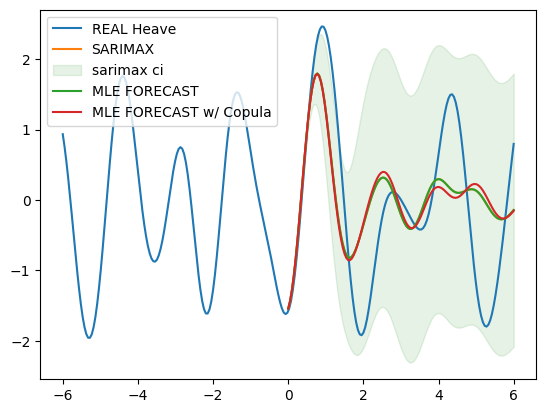

In [26]:
#importing data for graph 

y_graph1 = list(y_heave[-horizon:3000])
y_graph1 = y_graph1 + list(y_test_heave)

sarimax_ci_down1 = sarimax_res1.get_forecast(125).summary_frame()["mean_ci_lower"]
sarimax_ci_up1 = sarimax_res1.get_forecast(125).summary_frame()["mean_ci_upper"]


fig, ax = plt.subplots()
ax.plot(np.linspace(-6,6,250),y_graph1)

ax.plot(np.linspace(0,6,125),sarimax_res1.forecast(125))
ax.fill_between(np.linspace(0,6,125), sarimax_ci_up1, sarimax_ci_down1, color='green', alpha=.1)

plt.plot(np.linspace(0,6,125),forecast_param)
plt.plot(np.linspace(0,6,125),forecast1_param_copula)



plt.legend([ "REAL Heave","SARIMAX", "sarimax ci",  "MLE FORECAST", "MLE FORECAST w/ Copula"])

plt.show()

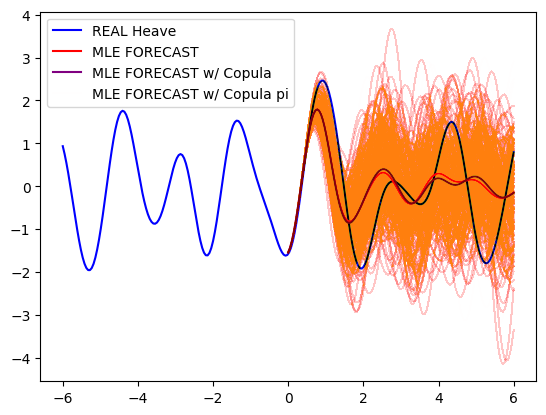

In [27]:
fig, ax = plt.subplots()

ax.plot(np.linspace(-6,6,250),y_graph1, color = "blue")
plt.plot(np.linspace(0,6,125),forecast_param, color = "red")
plt.plot(np.linspace(0,6,125),forecast1_param_copula, color = "purple")

for i in range(repeats):
    plt.plot(np.linspace(0,6,125),pi_1[:, i],color='C1', alpha=.002) #0.002


plt.legend([  "REAL Heave",  "MLE FORECAST", "MLE FORECAST w/ Copula"  ,"MLE FORECAST w/ Copula pi"])

plt.show()

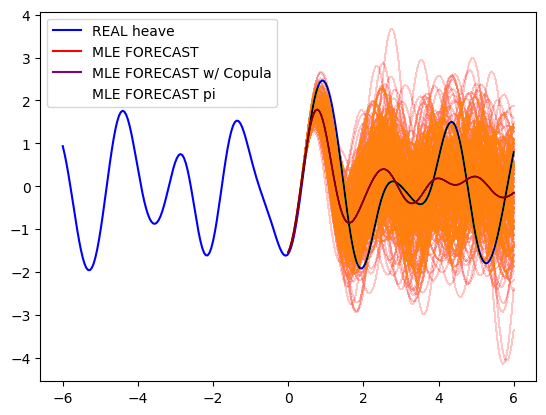

In [28]:
fig, ax = plt.subplots()

ax.plot(np.linspace(-6,6,250),y_graph1, color = "blue")
plt.plot(np.linspace(0,6,125),forecast1b_param, color = "red")
plt.plot(np.linspace(0,6,125),forecast1_param_copula, color = "purple")

for i in range(repeats):
    plt.plot(np.linspace(0,6,125),pi_1b[:, i],color='C1', alpha=.002) #0.002


plt.legend([  "REAL heave",  "MLE FORECAST", "MLE FORECAST w/ Copula"  ,"MLE FORECAST pi"])

plt.show()

In [29]:
print("MSE of predicted to true for MLE",mse(y_test_heave, forecast1b_param))
print("MSE of predicted to true for MLE w/ copula",mse(y_test_heave, forecast1_param_copula))

mse(forecast1b_param, forecast1_param_copula)

MSE of predicted to true for MLE [0.80906824]
MSE of predicted to true for MLE w/ copula 0.8090697499988501


array([8.57286508e-11])

In [30]:
y_graph2 = list(y_incident[-125:3000])
print(len(y_graph2), len(y_test_incident))
y_graph2 = y_graph2 + list(y_test_incident)

sarimax_ci_down2 = sarimax_res2.get_forecast(125).summary_frame()["mean_ci_lower"]
sarimax_ci_up2 = sarimax_res2.get_forecast(125).summary_frame()["mean_ci_upper"]

125 125


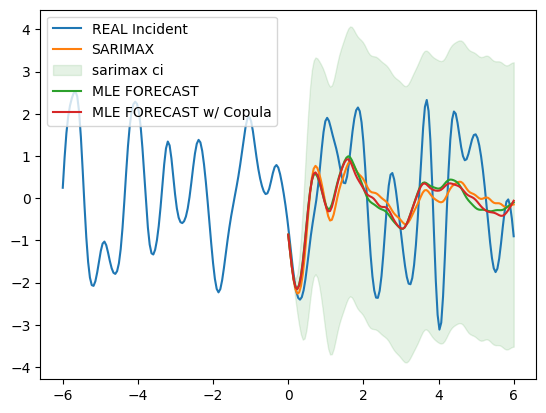

In [31]:
fig, ax = plt.subplots()
ax.plot(np.linspace(-6,6,250),y_graph2)

ax.plot(np.linspace(0,6,125),sarimax_res2.forecast(125))
ax.fill_between(np.linspace(0,6,125), sarimax_ci_up2, sarimax_ci_down2, color='green', alpha=.1)

plt.plot(np.linspace(0,6,125),forecast_param_incident)
plt.plot(np.linspace(0,6,125),forecast2_param_copula)


plt.legend([ "REAL Incident", "SARIMAX", "sarimax ci",  "MLE FORECAST", "MLE FORECAST w/ Copula"])

plt.show()

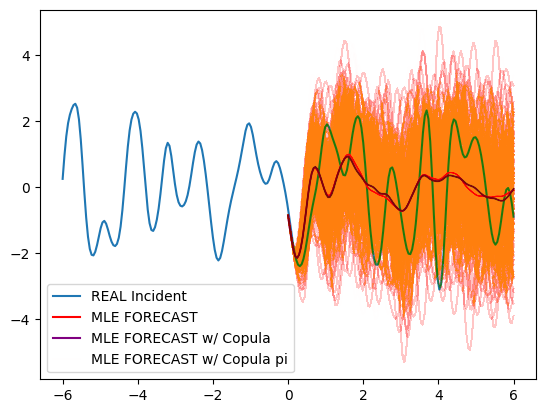

In [32]:
fig, ax = plt.subplots()
ax.plot(np.linspace(-6,6,250),y_graph2)
plt.plot(np.linspace(0,6,125),forecast_param_incident, color = "red")
plt.plot(np.linspace(0,6,125),forecast2_param_copula, color = "purple")

for i in range(repeats):
    plt.plot(np.linspace(0,6,125),pi_2[:,i],color='C1', alpha=.002)

plt.legend([ "REAL Incident",  "MLE FORECAST", "MLE FORECAST w/ Copula","MLE FORECAST w/ Copula pi" ])

plt.show()

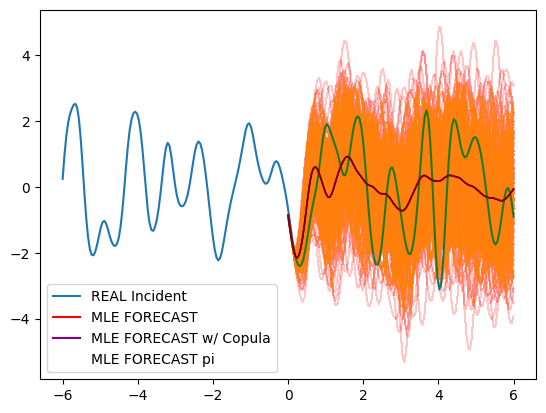

In [33]:
fig, ax = plt.subplots()
ax.plot(np.linspace(-6,6,250),y_graph2)
plt.plot(np.linspace(0,6,125),forecast2b_param, color = "red")
plt.plot(np.linspace(0,6,125),forecast2_param_copula, color = "purple")

for i in range(repeats):
    plt.plot(np.linspace(0,6,125),pi_2b[:,i],color='C1', alpha=.002)

plt.legend([ "REAL Incident",  "MLE FORECAST", "MLE FORECAST w/ Copula","MLE FORECAST pi" ])

plt.show()

In [34]:
print("MSE of predicted to true for MLE",mse(y_test_incident, forecast2b_param))
print("MSE of predicted to true for MLE w/ copula",mse(y_test_incident, forecast2_param_copula))
mse(forecast2b_param, forecast2_param_copula )

MSE of predicted to true for MLE [1.55113342]
MSE of predicted to true for MLE w/ copula 1.5511212549989795


array([1.07241485e-08])